# Determining the age of buyers

## Exploratory data analysis

At the first stage, we examine the size and main statistical indicators of the sample. Let's plot the age distribution in the sample. We will print photos of the first batch to understand whether additional image processing is required.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


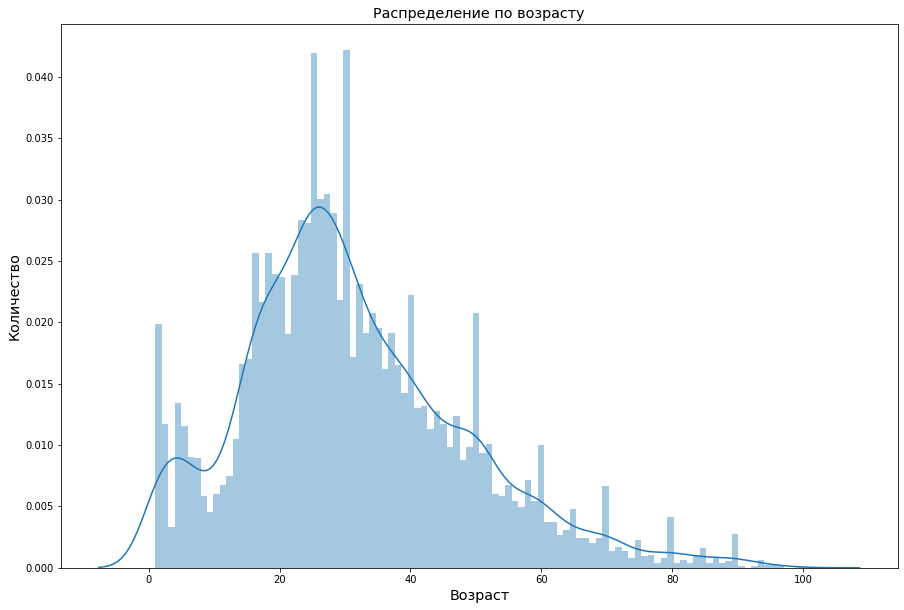

In [4]:
plt.figure(figsize=(15,10))
sns.distplot(labels["real_age"],  hist = True, bins=100)
plt.title('Распределение по возрасту', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large');

In [5]:
labels["real_age"].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

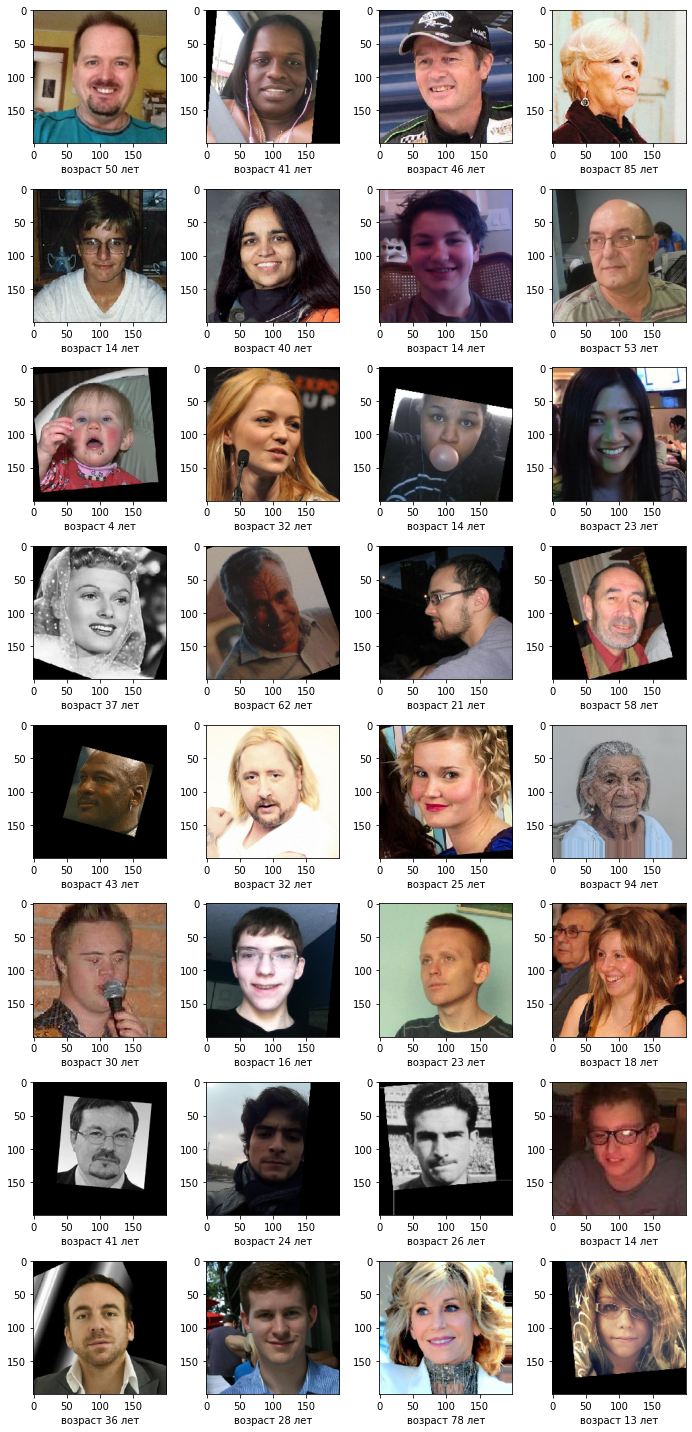

In [8]:
# Pictures from the first batch
fig = plt.figure(figsize=(10,20))
for i in range(32):
    fig.add_subplot(8, 4, i+1) 
    plt.imshow(train_gen_flow[0][0][i])
    plt.xlabel(
        f'возраст {train_gen_flow[0][1][i]} лет')
        
    plt.tight_layout()

Conclusions: The histogram of age distribution shows that the majority of photographs belong to people aged from 20 to 40, there are few outliers, possibly due to the fact that when marking, age was rounded to round values. As can be seen from the photographs, the primary augmentation has already been carried out: some photographs are rotated and shifted. Therefore, preliminary augmentation is not required. This is also indicated in the dataset description on the website. The size of the images differs, but this is also taken into account during processing.

## Model training

```python


import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

#Вывод после запуска обучения:

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-09-06 18:39:13.398377: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-06 18:39:14.623695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 209.8290 - mae: 10.7572 - val_loss: 539.0303 - val_mae: 18.0807
Epoch 2/10
178/178 - 38s - loss: 101.6443 - mae: 7.6092 - val_loss: 408.9505 - val_mae: 15.1116
Epoch 3/10
178/178 - 38s - loss: 65.1020 - mae: 6.1540 - val_loss: 350.1402 - val_mae: 13.9087
Epoch 4/10
178/178 - 37s - loss: 44.3167 - mae: 5.1681 - val_loss: 195.5126 - val_mae: 10.2872
Epoch 5/10
178/178 - 37s - loss: 30.9008 - mae: 4.2868 - val_loss: 96.9748 - val_mae: 7.5480
Epoch 6/10
178/178 - 38s - loss: 22.2935 - mae: 3.6494 - val_loss: 76.9172 - val_mae: 6.6131
Epoch 7/10
178/178 - 37s - loss: 15.3305 - mae: 3.0242 - val_loss: 93.2276 - val_mae: 7.4355
Epoch 8/10
178/178 - 37s - loss: 12.7575 - mae: 2.7424 - val_loss: 82.0441 - val_mae: 6.8627
Epoch 9/10
Epoch 10/10
178/178 - 38s - loss: 11.4037 - mae: 2.6011 - val_loss: 84.2608 - val_mae: 6.9869
178/178 - 38s - loss: 10.1705 - mae: 2.4208 - val_loss: 75.9184 - val_mae: 6.4712
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 75.9184 - mae: 6.4712
Test MAE: 6.4712

```

```

## Analysis of the trained model

When training a model based on the ResNet50 neural network architecture, pretrained on ImageNet data, the required MAE of less than 7 was achieved in less than 10 epochs, which allows this model to be used for age prediction in individual business tasks. Such accuracy is still not enough for such tasks as, for example, determining age to assess the possibility of selling alcohol: 7 years is a large error for children's buyers.